In [7]:
import numpy as np
from random import *

# Set up environment

In [8]:
####################
# Helper Functions #
####################

def accumulate(fn, initial, seq):
    if not seq:
        return initial
    else:
        return fn(seq[0], 
                  accumulate(fn, initial, seq[1:]))
    
def flatten(mat):
    return [num for row in mat for num in row]

def has_zero(mat):
    return 0 in flatten(mat)

def transpose(mat):
    return list(map(list,zip(*mat)))

# Before Transpose:
# 1 2 3 4
# 5 6 7 8
# 9 10 11 12
# 13 14 15 16

# After Transpose
# 1 5 9 13
# 2 6 10 14
# 3 7 11 15
# 4 8 12 16


def reverse(mat):
    return list(map(lambda row: list(reversed(row)),mat))

# Before Reverse:
# 1 2 3 4
# 5 6 7 8
# 9 10 11 12
# 13 14 15 16

# After Reverse
# 4 3 2 1
# 8 7 6 5
# 12 11 10 9
# 16 15 14 13


###################
# Game Matrix ADT #
###################

def new_game_matrix(n):
    matrix = []
    for i in range(n):
        matrix.append([0] * n)
    return matrix


def add_two(mat):
    if not has_zero(mat):
        return mat
    a = randint(0, len(mat)-1)
    b = randint(0, len(mat)-1)
    while mat[a][b] != 0:
        a = randint(0, len(mat)-1)
        b = randint(0, len(mat)-1)
    mat[a][b] = 2
    return mat

def game_status(mat):
#     for row in mat:
#         for element in row:
#             if element == 8192:
#                 return 'win'

    if has_zero(mat):
        return 'not over'
    for i in range(len(mat)): #Check horizontally
        for j in range(len(mat[0])-1):
            if mat[i][j] == mat[i][j+1]:
                return 'not over'
    for i in range(len(mat)-1): #Check vertically
        for j in range(len(mat[0])):
            if mat[i][j] == mat[i+1][j]:
                return 'not over'
    return 'lose'

def merge_left(matrix):
    def merge_row(row):
        merged_row, prev_tile, score_increment = [], 0, 0
        # pack element by element left-wards
        for tile in row:
            if tile == 0: continue
            if prev_tile == 0:
                prev_tile = tile
            elif prev_tile != tile:
                merged_row.append(prev_tile)
                prev_tile = tile
            else:
                merged_row.append(prev_tile*2)
                score_increment += prev_tile*2
                prev_tile = 0
        merged_row.append(prev_tile) # valid regardless whether there are merges or not
        # top up zeros
        while len(merged_row) != len(row):
            merged_row.append(0)
        return (merged_row, merged_row != row, score_increment)

    return accumulate(lambda first, rest: ([first[0]] + rest[0], 
                                            first[1] or rest[1], 
                                            first[2] + rest[2]),
                      ([], False, 0),
                      list(map(merge_row, matrix)))

def merge_right(mat):
    mat, valid, score = merge_left(reverse(mat))
    return (reverse(mat), valid, score)

def merge_up(mat):
    mat, valid, score = merge_left(transpose(mat))
    return (transpose(mat), valid, score)

def merge_down(mat):
    mat, valid, score = merge_left(reverse(transpose(mat)))
    return (transpose(reverse(mat)), valid, score)


###################
# Game Record ADT #
###################
                
def make_new_record(mat, score):
    return (mat, score)
def get_record_matrix(record):
    return record[0]
def get_record_score(record):
    return record[1]


####################
# Game Records ADT #
####################

def new_records():
    return []
def add_record(new_record, records):
    NUM_OF_UNDOS = 3
    records.append(new_record)
    if num_of_records(records) > NUM_OF_UNDOS:
        records = records[-NUM_OF_UNDOS:]
    return records
def num_of_records(records):
    return len(records)
def is_empty(records):
    return num_of_records(records) <= 0
def pop_last_record(records):
    if not is_empty(records):
        last_record = records.pop()
        return (get_record_matrix(last_record),
                get_record_score(last_record),
                records)
    else:
        return (None, None, records)

##################
# Game State ADT #
##################

def make_state(matrix, total_score, history):
    return (matrix, total_score, history)
def get_matrix(state):
    return state[0]
def get_score(state):
    return state[1]
def get_history(state):
    return state[2]
def make_new_game(n):
    starting_matrix = add_two(add_two(new_game_matrix(n)))
    return make_state(starting_matrix, 0, new_records())

def execute_move(state, matrix_updater):   
    current_score = get_score(state)
    next_matrix, valid_move, score_increment = matrix_updater(get_matrix(state))
    if not valid_move:
        return (state, False)
    else:
        updated_history = ()
        updated_state = make_state(add_two(next_matrix),
                                   current_score + score_increment,
                                   updated_history)
        return (updated_state, True)
def left(state):
    return execute_move(state, merge_left)
def right(state):
    return execute_move(state, merge_right)
def up(state):
    return execute_move(state, merge_up)
def down(state):
    return execute_move(state, merge_down)

def undo(state):
    records = get_history(state)
    matrix, score, records = pop_last_record(records)
    if matrix:
        return (make_state(matrix, score, records), True)
    else:
        return (state, False)    

game_logic = {
    'make_new_game': make_new_game,
    'game_status': game_status,
    'get_score': get_score,
    'get_matrix': get_matrix,
    'up': up,
    'down': down,
    'left': left,
    'right': right,
    'undo': undo
}

# Random AI

In [9]:
def random_move(current_state):
    index = np.random.randint(4)
    return ["up", "down", "left", "right"][index]

In [10]:
!pip install seaborn
import seaborn as sns
!pip install matplotlib
import matplotlib.pyplot as plt

def printboardstate(boardstate):
    mat, score, _ = boardstate
    sns.heatmap(mat, annot = True, 
            square = True, cbar = False, cmap = 'YlOrBr', fmt = 'd')
    plt.title('Game State with Score ' + str(score))
    plt.axis('off')
    plt.show()

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Initial state:


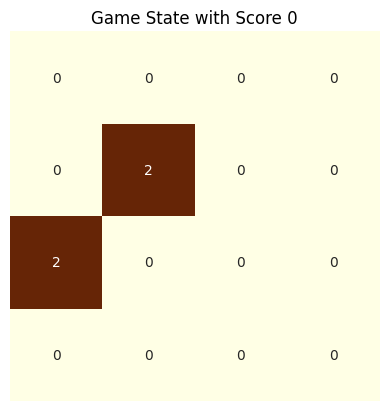

Final state:


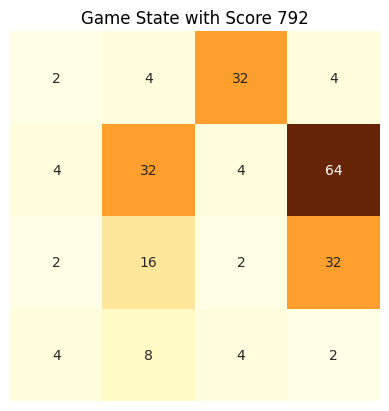

In [11]:
current_state = make_new_game(4)

print('Initial state:')
printboardstate(current_state)

while game_status(get_matrix(current_state)) == "not over":
    best_move = random_move(current_state)
    best_move = game_logic[best_move]
    current_state, _ = best_move(current_state)
    
print('Final state:')
printboardstate(current_state)

# Monte Carlo AI

In [12]:
def playthrough(gamestate, num_tries, max_depth):
    ''' Takes in a game state, and plays randomly till the end num_tries times, returns the final score '''
    score = 0
    for i in range(num_tries):
        newstate = gamestate
        depth = 0
        while game_status(get_matrix(newstate)) == "not over" and depth<max_depth:
            best_move = random_move(newstate)
            best_move = game_logic[best_move]
            newstate, _ = best_move(newstate)
            
            depth += 1
        score += newstate[1] - gamestate[1]
    
    return score/num_tries

Initial state:


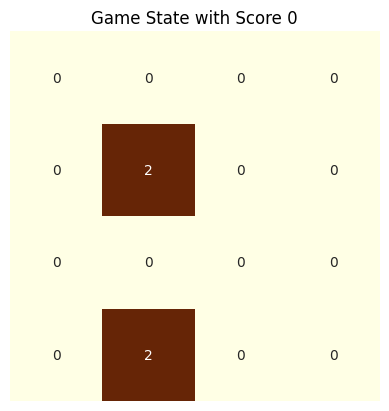

Score:
0 0 4 4 4 8 8 16 24 28 28 28 32 44 52 72 72 72 76 88 112 116 120 120 120 120 120 124 136 136 136 144 176 224 256 256 260 260 260 264 264 268 272 280 284 284 288 300 308 308 308 308 308 332 332 332 336 336 340 344 344 372 396 400 404 404 404 404 404 488 504 508 508 508 508 512 560 576 608 620 620 624 704 712 728 732 732 736 744 744 744 744 744 760 768 768 772 776 776 780 780 944 944 948 948 948 952 960 964 1012 1036 1036 1056 1064 1104 1108 1112 1112 1116 1120 1120 1124 1124 1124 1196 1196 1200 1220 1228 1228 1228 1232 1236 1280 1280 1284 1296 1320 1328 1336 1352 1384 1448 1452 1584 1596 1596 1596 1600 1608 1608 1612 1616 1616 1616 1616 1908 1908 1912 1912 1912 1912 1912 1916 1928 1952 1972 2008 2012 2012 2012 2044 2080 2088 2088 2092 2096 2096 2100 2108 2108 2108 2112 2120 2140 2144 2144 2144 2148 2228 2236 2236 2236 2236 2260 2268 2268 2272 2272 2316 2344 2344 2344 2348 2356 2356 2360 2360 2364 2372 2396 2404 2420 2420 2420 2424 2464 2472 2472 2492 2528 2528 2528 2532 2532 2620

KeyboardInterrupt: 

In [13]:
initial_state = make_new_game(4)
# initial_state = ([[0, 0, 0, 0], [8, 2, 0, 0], [4, 0, 0, 0], [4, 64, 8, 2]], 348, ())

print('Initial state:')
printboardstate(initial_state)

num_tries = 20
max_depth = 8
    
current_state = initial_state
print('Score:')
while game_status(get_matrix(current_state)) == "not over":
    # Only evaluate for valid moves
    bestscore = -1
    bestmove = ""
    
    for move in ['up', 'down', 'left', 'right']:
        _, valid = game_logic[move](current_state)
        if not valid: continue
        
        # perform monte carlo simulation for each of the valid moves
        montecarlo_state, _ = game_logic[move](current_state)
        montecarlo_score = playthrough(montecarlo_state, num_tries, max_depth)
        if montecarlo_score > bestscore:
            bestscore = montecarlo_score
            bestmove = move
    
    # do the move with the highest score
    current_state, _ = game_logic[bestmove](current_state)
    
#     print('Best move:', bestmove, 'Score:', current_state[1])
    print(current_state[1], end = ' ')
    
print('Final state:')
printboardstate(current_state)


# Monte Carlo Tree Search based AI

Initial state:


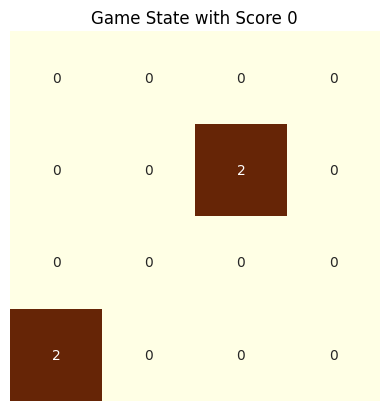

Score:
0 4 4 4 8 12 20 20 20 24 28 40 40 40 44 44 48 48 52 52 52 52 56 68 76 76 80 92 120 136 140 140 140 144 152 156 156 164 164 164 184 184 188 204 208 208 236 268 272 272 272 272 272 276 308 352 368 368 368 372 380 380 384 392 392 392 396 400 524 540 548 564 600 600 604 612 616 616 616 620 620 620 620 624 636 724 732 752 760 760 760 764 764 768 768 768 772 776 784 788 788 920 928 948 960 976 1008 1012 1012 1012 1012 1016 1024 1028 1032 1080 1096 1100 1100 1104 1112 1112 1112 1116 1200 1208 1228 1240 1256 1256 1260 1272 1272 1276 1320 1336 1368 1372 1436 1436 1448 1476 1476 1476 1476 1480 1484 1484 1616 1616 1616 1620 1628 1632 1632 1636 1636 1640 1640 1916 1924 1928 1944 1964 1964 1964 1964 1964 1968 1980 1980 1984 1992 2008 2012 2084 2084 2084 2088 2100 2100 2100 2104 2212 2212 2216 2220 2228 2244 2248 2248 2248 2252 2252 2256 2256 2296 2304 2304 2308 2320 2336 2336 2340 2368 2400 2400 2400 2404 2404 2484 2484 2492 2492 2496 2496 2500 2660 2668 2672 2684 2684 2688 2688 2692 2700 27

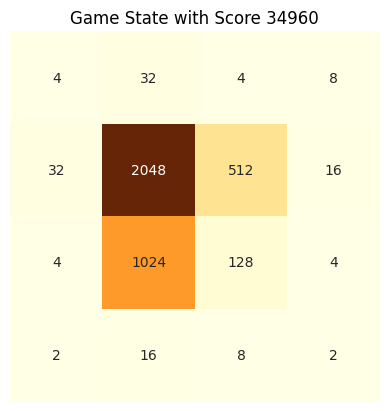

In [14]:
initial_state = make_new_game(4)

print('Initial state:')
printboardstate(initial_state)

debug = False

initial_tries = 20
num_tries = 20
max_depth = 15

indextomove = {0: 'up', 1: 'down', 2: 'left', 3: 'right'}
movetoindex = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
    
current_state = initial_state
print('Score:')
while game_status(get_matrix(current_state)) == "not over":
    # Only evaluate for valid moves
    bestscore = -1
    bestmove = ""
    validmoves = []
    
    action_score = np.array([0, 0, 0, 0])
    action_tries = np.array([0, 0, 0, 0])
    
    exploration_tries, exploration_score = 0, 0
    
    maxscore = 0
    
    for move in ['up', 'down', 'left', 'right']:
        _, valid = game_logic[move](current_state)
        if valid: validmoves.append(move)
        # if not valid, still increment the initial tries variable for that move to avoid division by 0
        else: 
            action_tries[movetoindex[move]] = initial_tries
            action_score[movetoindex[move]] = -1000000
            continue
        
        # do an initial exploration of each valid move
        for tries in range(initial_tries):
            # perform monte carlo simulation for that move
            montecarlo_state, _ = game_logic[move](current_state)
            montecarlo_score = playthrough(montecarlo_state, 1, max_depth)

            # add the score and tries to the action node
            maxindex = movetoindex[move]
            action_tries[maxindex] += 1
            action_score[maxindex] += montecarlo_score
            
            exploration_tries += 1
            exploration_score += montecarlo_score
    
    # we peg the exploration constant to the average montecarlo score of the initial trials
    c = exploration_score/exploration_tries
#     c = 10
            
    for totaltries in range(num_tries):
        
        # perform an explore-exploit tradeoff calculation to find out which move to go first
        action_heuristic = action_score/action_tries + c*np.sqrt(np.log(totaltries+1)/action_tries)
        
#         print(action_heuristic)
#         print(np.sqrt((totaltries+1)/action_tries))
#         print('Exploration',c*np.sqrt(np.log(totaltries+1)/action_tries))
        
        maxindex = np.argmax(action_heuristic)        
        move = indextomove[maxindex]
        
        # perform monte carlo simulation for that move
        montecarlo_state, _ = game_logic[move](current_state)
        montecarlo_score = playthrough(montecarlo_state, 1, max_depth)
        
        # add the score and tries to the action node
        action_tries[maxindex] += 1
        action_score[maxindex] += montecarlo_score
        
        
    if debug:
        print('Exploration Factor', c)
        print('Number of tries', action_tries)
        print('Average score', action_score/action_tries)

        
    # best move is the highest score
#     bestmoveindex = np.where(action_tries == max(action_tries))[0][0]
    bestmoveindex = np.argmax(action_score/action_tries)
    bestmove = indextomove[bestmoveindex]
    
    # do the move with the highest score
    current_state, _ = game_logic[bestmove](current_state)
    
    if debug:
        print('Best move:', bestmove)
    print(current_state[1], end = ' ')

print('Final state:')
printboardstate(current_state)

# DQN